In [1]:
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import os, sys, math, random, copy, time
import datasets, custom_transforms, models
import cv2
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Settings

In [2]:
# Parameters
N_CLASSES = 2 # or 3
BATCH_SIZE = 64
num_epochs=20
ini_lr=1e-6
top_cutoff_percent = 0.08
class_weights = [1000/896, 1] # NONCOVID, COVID

TRAIN_DATA_DIR = 'D:/data/DanielCustomNetwork/DanielDataSets_Original/train/'
VAL_DATA_DIR = 'D:/data/DanielCustomNetwork/DanielDataSets_Original/val/'

checkpoint_save_path=os.path.join('checkpoints', str(N_CLASSES)+"Class", "DanielCheckpoints_cleanedReduced_224_v2")




# Preprocessing settings:
interp_mode = torchvision.transforms.InterpolationMode.NEAREST
image_size_to_VGG =224 # resize input images to this size in VGG
model_name = "VGG"
num_channels = 3 # because VGG is trained on RGB images

limit_save_epoch_acc=0.9

a = Path(checkpoint_save_path)
a.mkdir(parents=True, exist_ok=True)

# Data Preprocessing

In [3]:
# Data Preprocessing and Transforms
# Assumes importing images as PIL Images
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

class Equalise(object):
    # Histogram equalisation
    # Only works on PIL images
    def __init__(self, mask=None):
        self.mask = mask
    def __call__(self, image):
        return ImageOps.equalize(image, self.mask)
    
class ImageComplement(object):
    # Flip image intensities (i.e. black becomes white, white becomes black)
    # Assumes input image is a tensor with range[0,1]
    def __init__(self, probability=0.5):
        self.probability = probability
    def __call__(self, image):
        activate = np.random.uniform(0,1)
        if activate < self.probability:
            # Flip
            max_image = torch.max(image)
            min_image = torch.min(image)
            #print("min:{},max:{}".format(min_image, max_image))
            image = (image-min_image)/(max_image-min_image) # range [0,1]
            image = (1-image)*(max_image-min_image) + min_image # back to original range
        return image



train_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode), # PIL image
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    torchvision.transforms.RandomHorizontalFlip(),
                                    torchvision.transforms.ColorJitter(brightness=0.1), # this jitters brightness
                                    torchvision.transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
                                    ImageComplement(),
                                    normalize,
                                    ])

val_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode),
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    normalize,
                                ])

import datasets
train_dataset = datasets.Coviddataset(normal_path=os.path.join(TRAIN_DATA_DIR,"NORMAL"),
                                      pneumonia_path=os.path.join(TRAIN_DATA_DIR,"PNEUMONIA"),
                                      covid_path=os.path.join(TRAIN_DATA_DIR,"COVID"),
                                      transform = train_transforms,
                                     NClasses=N_CLASSES, unbias=True,channels=num_channels)
val_dataset = datasets.Coviddataset(normal_path=os.path.join(VAL_DATA_DIR,"NORMAL"),
                                    pneumonia_path=os.path.join(VAL_DATA_DIR,"PNEUMONIA"),
                                    covid_path=os.path.join(VAL_DATA_DIR,"COVID"),
                                    transform = val_transforms,
                                   NClasses=N_CLASSES, unbias=True, channels=num_channels )

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, pin_memory=True)

dataloaders = {'train':train_loader,'val':val_loader}
train_number=len(train_dataset);val_number=len(val_dataset)
dataset_sizes={'train':train_number,'val':val_number}

RAW DATASET STATISTICS:-----------
Normal:1000, Pneumonia:1000, COVID:896
2-Class Dataset Statistics:-----------
Noncovid:1000, COVID:896
RAW DATASET STATISTICS:-----------
Normal:100, Pneumonia:100, COVID:100
2-Class Dataset Statistics:-----------
Noncovid:100, COVID:100


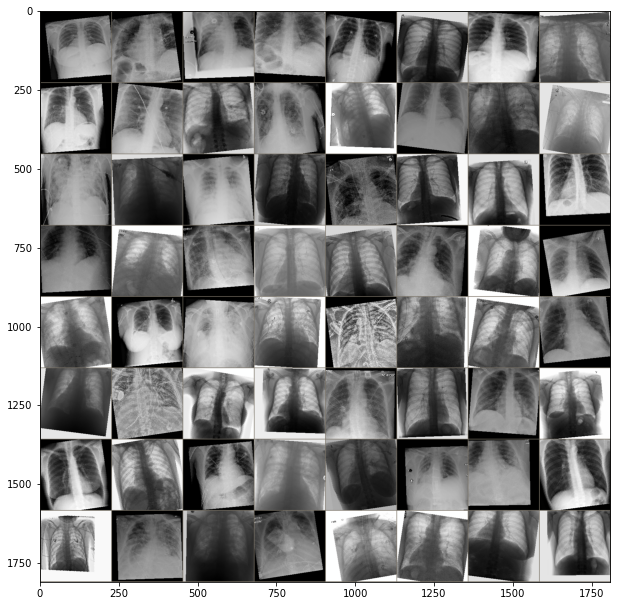

In [4]:
# DEBUGGING
sample = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(sample["image"])
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
imshow(out)

# Network

In [5]:
model = models.get_model_vgg16(N_CLASSES)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=ini_lr, betas=(0.9,0.999))

# LR Scheduler
exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                                                              threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, 
                                                              eps=1e-08, verbose=False)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    history_accuracy = {"train":[], "val":[]}
    history_loss = {"train":[], "val":[]}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in history_loss.keys():
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs=data["image"]
                labels=data["label"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # Record histories
            history_accuracy[phase].append(epoch_acc)
            history_loss[phase].append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc and epoch_acc > limit_save_epoch_acc:
                best_acc = epoch_acc
                print("Achieved current highest accuracy of: {}".format(best_acc))
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict()
                }, os.path.join(checkpoint_save_path,
                                'balance[epoch_{}_loss_{:.3f}_acc_{:.3f}].pt'.format((epoch), history_loss[phase][-1],
                                                                                            history_accuracy[phase][-1])))
            
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    history = {"accuracy":history_accuracy, "loss":history_loss}
    return model, history


def set_parameter_requires_grad(model, feature_extracting):
    # If feature extracting only.
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/19
----------


C:\Users\nfdlam\.conda\envs\AI_cuda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6841 Acc: 0.5686
val Loss: 0.6493 Acc: 0.5600

Epoch 1/19
----------
train Loss: 0.5913 Acc: 0.6967
val Loss: 0.5796 Acc: 0.6350

Epoch 2/19
----------
train Loss: 0.5107 Acc: 0.7727
val Loss: 0.5091 Acc: 0.6900

Epoch 3/19
----------
train Loss: 0.4071 Acc: 0.8639
val Loss: 0.4207 Acc: 0.8250

Epoch 4/19
----------
train Loss: 0.3223 Acc: 0.8987
val Loss: 0.3077 Acc: 0.8900

Epoch 5/19
----------
train Loss: 0.2247 Acc: 0.9383
val Loss: 0.2141 Acc: 0.9400
Achieved current highest accuracy of: 0.9400000000000001

Epoch 6/19
----------
train Loss: 0.1571 Acc: 0.9610
val Loss: 0.1459 Acc: 0.9700
Achieved current highest accuracy of: 0.97

Epoch 7/19
----------
train Loss: 0.1154 Acc: 0.9657
val Loss: 0.1100 Acc: 0.9750
Achieved current highest accuracy of: 0.975

Epoch 8/19
----------


In [ ]:
# Graph Visualisation
import matplotlib.pyplot as plt

epoch_list= list(i for i in range(0,num_epochs))

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].set(title='Train/Val Loss', xlabel='Epoch', ylabel='Loss' )
ax[0].plot(epoch_list, history["loss"]['train'],linewidth=2,linestyle=':',label='Train Loss', marker='o')
ax[0].plot(epoch_list, history["loss"]['val'], linewidth=1, linestyle='--', label='Val Loss', marker='+')
ax[0].legend(loc=2)

ax[1].set(title='Train/Val Acc', xlabel='Epoch', ylabel='Acc' )
ax[1].plot(epoch_list, history["accuracy"]['train'], linewidth=2, linestyle=':', label='Train Acc', marker='o')
ax[1].plot(epoch_list, history["accuracy"]['val'], linewidth=1, linestyle='--', label='Val Acc', marker='+')
ax[1].legend(loc=2)
plt.savefig(os.path.join(checkpoint_save_path,"lossaccpic_"+str(N_CLASSES)+"class.png"), bbox_inches='tight')

plt.show()